In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd ## to open mnist data

In [ ]:
device = 'cuda' ## try of GPU

In [ ]:
## download data
train = pd.read_csv('mnist_train.csv')

In [ ]:
## normalize data
train_data = train.drop(labels = ['label'], axis = 1)
train_data = train_data.values.reshape(-1, 28, 28)
train_data = train_data/255.0

del train 

In [ ]:
print(train_data.shape)

(60000, 28, 28)


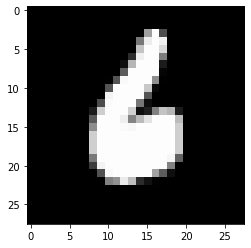

In [ ]:
## example of MNIST picture
plt.imshow(train_data[1337], cmap = 'gray')

In [ ]:
train_data = torch.Tensor(train_data)
random_seed = 1
batch_size = 32
train_dl = DataLoader(train_data, batch_size, shuffle = True)

In [ ]:
## function to crete random picture
def random_image(batch_size, dim):
    return torch.rand(batch_size, dim)*2 - 1

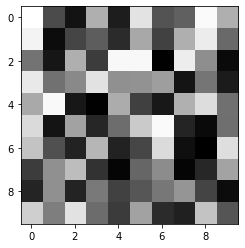

In [ ]:
## try of random picture
a = random_image(64, 100)
b = a[2]
b = b.reshape(10, 10)
plt.imshow(b.numpy(), cmap = 'gray')

In [ ]:
## create Discriminator
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1)
        self.conv0_drop = nn.Dropout2d(0.25)

        self.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_drop = nn.Dropout2d(0.25)

        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_drop = nn.Dropout2d(0.25)

        self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)
        self.conv3_drop = nn.Dropout2d(0.25)

        self.fc = nn.Linear(128 * 98, 1)
    
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.leaky_relu(self.conv0(x), 0.2)
        x = self.conv0_drop(x)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = self.conv1_drop(x)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = self.conv2_drop(x)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = self.conv3_drop(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features



## create Generator 
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(100, 256*7*7)

        self.trans_conv1 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)

        self.trans_conv2 = nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 1, padding = 1)

        self.trans_conv3 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)

        self.trans_conv4 = nn.ConvTranspose2d(32, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
    
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 256, 7, 7)
        x = F.relu(self.trans_conv1(x))
        x = F.relu(self.trans_conv2(x))
        x = F.relu(self.trans_conv3(x))
        x = self.trans_conv4(x)
        x = torch.tanh(x)
        
        return x               

In [ ]:
Discr = Discriminator()
Gener = Generator()

In [ ]:
Discr = Discr.to(device)
Gener = Gener.to(device)
Discr = Discr.float()
Gener = Gener.float()

In [ ]:
print(Discr)
print(Gener)

Discriminator(
  (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv0_drop): Dropout2d(p=0.25, inplace=False)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_drop): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3_drop): Dropout2d(p=0.25, inplace=False)
  (fc): Linear(in_features=12544, out_features=1, bias=True)
)
Generator(
  (fc): Linear(in_features=100, out_features=12544, bias=True)
  (trans_conv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (trans_conv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (trans_conv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (trans_conv4): ConvTranspose2d(32, 1, 

In [ ]:
## loss function and function to calculate loss

Loss = nn.BCEWithLogitsLoss()
def discriminator_real_loss(real_out):
    real_label = torch.ones(real_out.size()[0], 1).to(device)
    real_loss = Loss(real_out.squeeze(), real_label.squeeze())
    return real_loss

def discriminator_fake_loss(fake_out):
    fake_label = torch.zeros(fake_out.size()[0], 1).to(device)
    fake_loss = Loss(fake_out.squeeze(), fake_label.squeeze())
    return fake_loss

def discriminator_loss(real_out, fake_out):
    real_loss = discriminator_real_loss(real_out)
    fake_loss = discriminator_fake_loss(fake_out)
    total_loss = (real_loss + fake_loss)
    return total_loss

In [ ]:
## function to calculate loss
def generator_loss(gen_disc_out):
    label = torch.ones(gen_disc_out.size()[0], 1).to(device)
    gen_loss = Loss(gen_disc_out.squeeze(), label.squeeze())
    return gen_loss

In [ ]:
## optimizers
optim_g = optim.Adam(Discr.parameters(), lr = 0.0001)
optim_d = optim.Adam(Gener.parameters(), lr = 0.0001)

In [ ]:
## function to train our model
def train(Discr, Gener, optim_d, optim_g, train_dl, batch_size=32, epochs=20):
    d_losses = []
    g_losses = []


    fake = random_image(16, 100)
    fake = fake.to(device)

    Discr.train()
    Gener.train()

    for epoch in range(epochs):

        d_loss_total = 0
        g_loss_total = 0

        for train_x in train_dl:
            optim_d.zero_grad()

            train_x = train_x * 2 - 1
            train_x = train_x.to(device)
            real_out = Discr(train_x.float())

            disc_gen_in = random_noise_generator(batch_size, 100)
            disc_gen_in = disc_gen_in.to(device)

            disc_gen_out = Gener(disc_gen_in.float()).detach()
            fake_out = Discr(disc_gen_out.float())

            disc_loss = discriminator_loss(real_out, fake_out)
            d_loss_total += disc_loss
            disc_loss.backward()
            optim_d.step()

            optim_g.zero_grad()

            gen_out = Gener(disc_gen_in.float())
            gen_disc_out = Discr(gen_out.float())

            gen_loss = generator_loss(gen_disc_out)
            g_loss_total += gen_loss
            gen_loss.backward()
            optim_g.step()

        d_losses.append(d_loss_total)
        g_losses.append(g_loss_total)

        if epoch % 2 == 0:
            Gener.eval()      
            samples = Gener(fake.float())
            Gener.train()

            fig, axes = plt.subplots(figsize=(7, 7), nrows=4, ncols=4, sharey=True, sharex=True)
            for ax, img in zip(axes.flatten(), samples):
                img = img.cpu().detach()
                ax.xaxis.set_visible(False)
                ax.yaxis.set_visible(False)
                im = ax.imshow(img.reshape((28, 28)), cmap='Greys_r')

        print("for epoch №", epoch, "d_loss = ", (d_loss_total / len(train_dl)).item(), "g_loss = ", (g_loss_total / len(train_dl)).item())

    return d_losses, g_losses

for epoch № 0 d_loss =  1.2895950078964233 g_loss =  0.8554763793945312
for epoch № 1 d_loss =  1.288686752319336 g_loss =  0.8566407561302185
for epoch № 2 d_loss =  1.2893086671829224 g_loss =  0.8535957932472229
for epoch № 3 d_loss =  1.2874352931976318 g_loss =  0.8621842265129089
for epoch № 4 d_loss =  1.291741132736206 g_loss =  0.8528722524642944
for epoch № 5 d_loss =  1.2935720682144165 g_loss =  0.8507859706878662
for epoch № 6 d_loss =  1.291773796081543 g_loss =  0.8519417643547058
for epoch № 7 d_loss =  1.2917611598968506 g_loss =  0.8549136519432068
for epoch № 8 d_loss =  1.2931135892868042 g_loss =  0.8548567891120911
for epoch № 9 d_loss =  1.293157935142517 g_loss =  0.8484035730361938
for epoch № 10 d_loss =  1.2919386625289917 g_loss =  0.8450033068656921
for epoch № 11 d_loss =  1.294890284538269 g_loss =  0.8490076661109924
for epoch № 12 d_loss =  1.2954862117767334 g_loss =  0.8474400639533997
for epoch № 13 d_loss =  1.293579339981079 g_loss =  0.85009646415

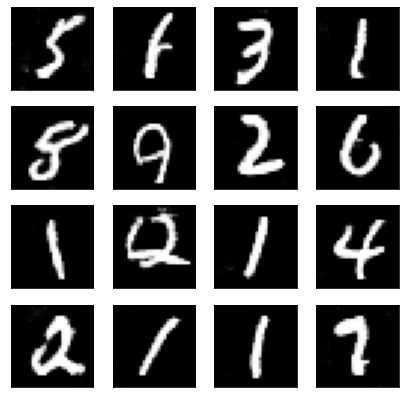

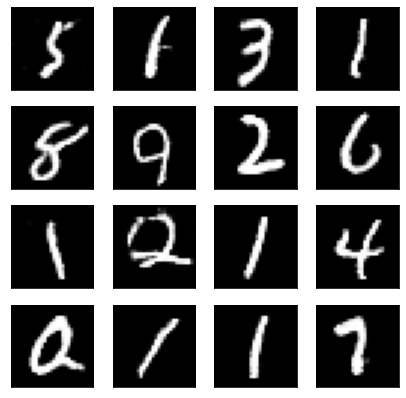

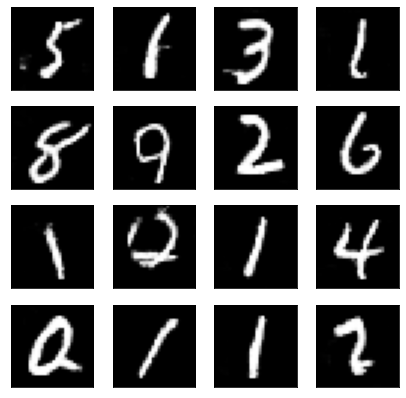

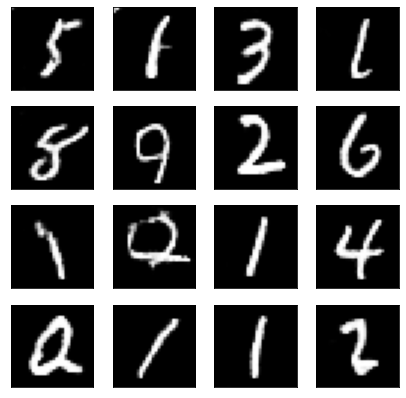

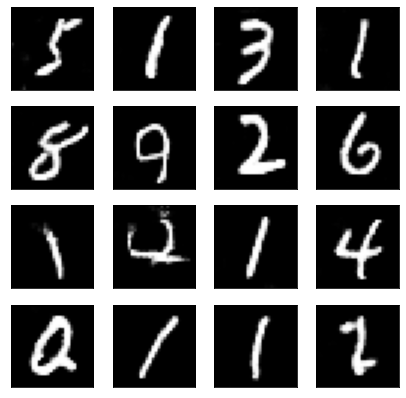

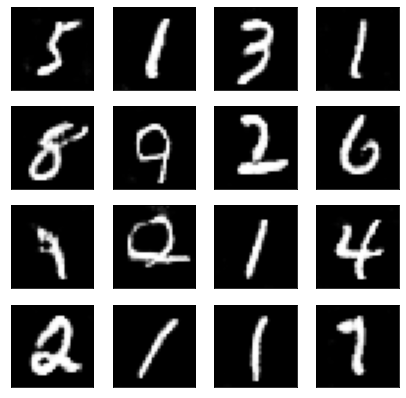

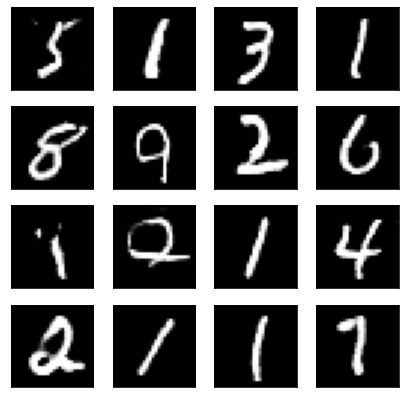

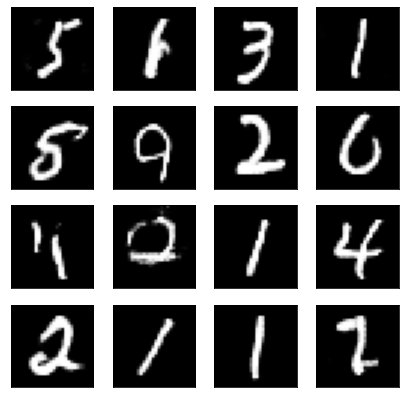

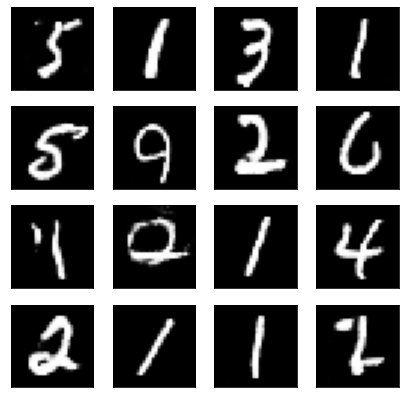

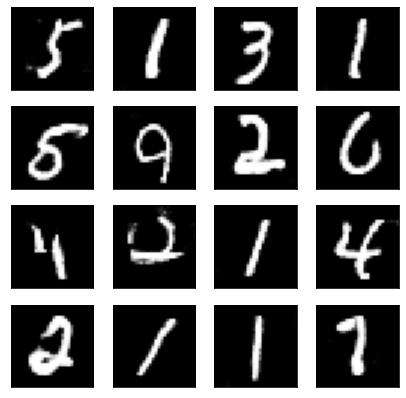

In [ ]:
d_losses, g_losses = train(Discr, Gener, optim_g, optim_d, train_dl)

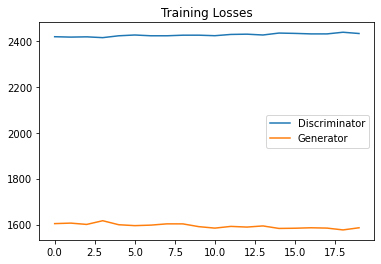

In [ ]:
## graph of losses
fig, ax = plt.subplots()
d_losses = np.array(d_losses)
g_losses = np.array(g_losses)
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.title("Training Losses")
plt.legend()

In [ ]:
## function to train for a long time
def long_train(Discr, Gener, optim_d, optim_g, train_dl, batch_size=32, epochs=200):
    d_losses = []
    g_losses = []


    fake = random_image(16, 100)
    fake = fake.to(device)

    Discr.train()
    Gener.train()

    for epoch in range(epochs + 1):

        d_loss_total = 0
        g_loss_total = 0

        for train_x in train_dl:
            optim_d.zero_grad()

            train_x = train_x * 2 - 1
            train_x = train_x.to(device)
            real_out = Discr(train_x.float())

            disc_gen_in = random_noise_generator(batch_size, 100)
            disc_gen_in = disc_gen_in.to(device)

            disc_gen_out = Gener(disc_gen_in.float()).detach()
            fake_out = Discr(disc_gen_out.float())

            disc_loss = discriminator_loss(real_out, fake_out)
            d_loss_total += disc_loss
            disc_loss.backward()
            optim_d.step()

            optim_g.zero_grad()

            gen_out = Gener(disc_gen_in.float())
            gen_disc_out = Discr(gen_out.float())

            gen_loss = generator_loss(gen_disc_out)
            g_loss_total += gen_loss
            gen_loss.backward()
            optim_g.step()

        d_losses.append(d_loss_total)
        g_losses.append(g_loss_total)

        if epoch % 40 == 0:
            Gener.eval()      
            samples = Gener(fake.float())
            Gener.train()

            fig, axes = plt.subplots(figsize=(7, 7), nrows=4, ncols=4, sharey=True, sharex=True)
            for ax, img in zip(axes.flatten(), samples):
                img = img.cpu().detach()
                ax.xaxis.set_visible(False)
                ax.yaxis.set_visible(False)
                im = ax.imshow(img.reshape((28, 28)), cmap='Greys_r')

        print("for epoch №", epoch, "d_loss = ", (d_loss_total / len(train_dl)).item(), "g_loss = ", (g_loss_total / len(train_dl)).item())

    return d_losses, g_losses

In [ ]:
long_d_losses, long_g_losses = long_train(Discr, Gener, optim_g, optim_d, train_dl)

for epoch № 0 d_loss =  1.3058686256408691 g_loss =  0.8367148637771606
for epoch № 1 d_loss =  1.3033393621444702 g_loss =  0.8328775763511658
for epoch № 2 d_loss =  1.303385853767395 g_loss =  0.8378717303276062
for epoch № 3 d_loss =  1.304604172706604 g_loss =  0.8323074579238892
for epoch № 4 d_loss =  1.3000195026397705 g_loss =  0.8354557156562805
for epoch № 5 d_loss =  1.302499771118164 g_loss =  0.8365105390548706
for epoch № 6 d_loss =  1.303943395614624 g_loss =  0.8345897197723389
for epoch № 7 d_loss =  1.3045097589492798 g_loss =  0.8346824049949646
for epoch № 8 d_loss =  1.303469181060791 g_loss =  0.8329201340675354
for epoch № 9 d_loss =  1.3022410869598389 g_loss =  0.8319300413131714
for epoch № 10 d_loss =  1.302066445350647 g_loss =  0.8338415622711182
for epoch № 11 d_loss =  1.3028771877288818 g_loss =  0.8372665643692017
for epoch № 12 d_loss =  1.3036746978759766 g_loss =  0.8353195786476135
for epoch № 13 d_loss =  1.3027580976486206 g_loss =  0.83454531431

In [ ]:
fig, ax = plt.subplots()
long_d_losses = np.array(long_d_losses)
long_g_losses = np.array(long_g_losses)
plt.plot(long_d_losses, label='Discriminator')
plt.plot(long_g_losses, label='Generator')
plt.title("Training Losses")
plt.legend()